<a href="https://colab.research.google.com/github/Pankhuri9026/quora-question-pairs/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install nltk

In [ ]:
!pip install pandas

In [ ]:
!pip install distance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.3/180.3 kB 1.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for distance: filename=Distance-0.1.3-py3-none-any.whl size=16258 sha256=69bc8c87126961b76ebd7fbed2feb79a7d2625f68fd84152ce59a5401fc5d1c9
  Stored in directory: /root/.cache/pip/wheels/e8/bb/de/f71bf63559ea9a921059a5405806f7ff6ed612a9231c4a9309
Successfully built distance


In [ ]:
!pip install fuzzywuzzy

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
from bs4 import BeautifulSoup

import warnings
warnings.filterwarnings('ignore')

import string
import distance
import time
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

from fuzzywuzzy import fuzz
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


ModuleNotFoundError: No module named 'fuzzywuzzy'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/train.csv')

In [ ]:
df.shape

(404290, 6)

In [ ]:
df = df.sample(15000, random_state = 1)

In [ ]:
df.head(6)

,id,qid1,qid2,question1,question2,is_duplicate
237030,237030,33086,348102,How can I stop playing video games?,Should I stop playing video games with my child?,0
247341,247341,73272,8624,Who is better Donald Trump or Hillary Clinton?,Why is Hillary Clinton a better choice than Do...,1
246425,246425,359482,359483,What do you think is the chance that sometime ...,Do you think there will be another world war/n...,1
306985,306985,1357,47020,Why are so many questions posted to Quora that...,Why do people write questions on Quora that co...,1
225863,225863,334315,334316,Can there even be a movie ever rated 10/10 on ...,What are your 10/10 movies?,0
259303,259303,6304,375056,Which is correct: each of you is or each of ...,What is the difference between leafs and leave...,0


In [ ]:
df.isnull().sum()#missing values

id              0
qid1            0
qid2            0
question1       1
question2       0
is_duplicate    0
dtype: int64

In [ ]:
df.dropna(inplace=True)

<Axes: >

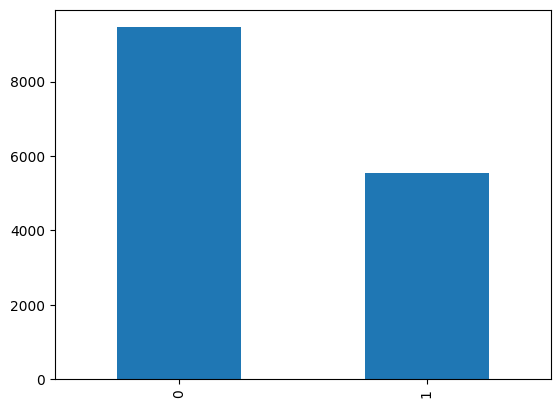

In [ ]:
df['is_duplicate'].value_counts().plot(kind='bar')

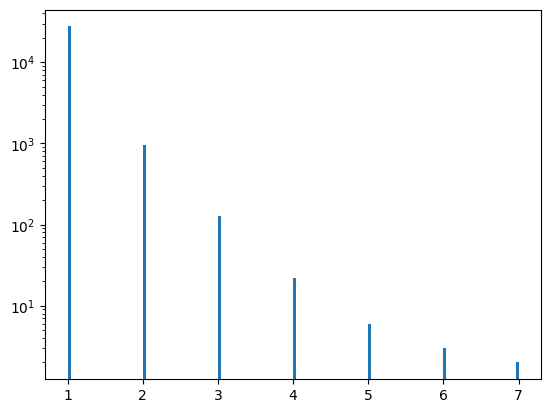

In [ ]:
qid = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
#repeated question histogram
plt.hist(qid.value_counts().values,bins=150)
plt.yscale('log')
plt.show()

In [ ]:
def preprocess(text):
  #lower case
  text = str(text).lower().strip()

  #remove emoji
  if(type(text) == str):
    emoji_pattern = re.compile("["
                                u"\U0001F600-\U0001F64F"  # emoticons
                                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                u"\U0001F700-\U0001F77F"  # alchemical symbols
                                u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                                u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                                u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                                u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                                u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                                u"\U00002702-\U000027B0"  # Dingbats
                                u"\U000024C2-\U0001F251"
                                "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)

  #remove html
  text = BeautifulSoup(text)
  text = text.get_text()

  #remove url
  if isinstance(text, str):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    result = url_pattern.sub('', text)
    text = result

  # Replace certain special characters with their string equivalents
  text = text.replace('%', ' percent')
  text = text.replace('$', ' dollar ')
  text = text.replace('₹', ' rupee ')
  text = text.replace('€', ' euro ')
  text = text.replace('@', ' at ')
  text = text.replace('[math]', '')

  #contractions
  contractions = {
    "'ve": " have",
    "n't": " not",
    "'re": " are",
    "'ll": " will",
    "ain't": "am not",
    "aren't": "are not",
    "can't": "can not",
    "can't've": "can not have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
    }

  text_decontracted = []
  for word in text.split():
    if word in contractions:
      word = contractions[word]
    text_decontracted.append(word)
  text = ' '.join(text_decontracted)

  #remove puntuations
  pattern = re.compile('\W')
  text = re.sub(pattern, ' ', text).strip()

  """
  # Tokenize the text
  tokens = word_tokenize(text)

  # Initialize the Porter Stemmer
  porter = PorterStemmer()

  # Stem each token in the text
  stemmed_text = [porter.stem(word) for word in tokens]

  # Join the stemmed tokens back into a single string
  stemmed_text_str = ' '.join(stemmed_text)
  """

  return text


In [ ]:
df['question1'] = df['question1'].apply(preprocess)
df['question2'] = df['question2'].apply(preprocess)

In [ ]:
df['q1_len'] = df['question1'].str.len()
df['q2_len'] = df['question2'].str.len()
#sns.pairplot(df[['q1_len', 'q2_len', 'is_duplicate']], hue='is_duplicate')

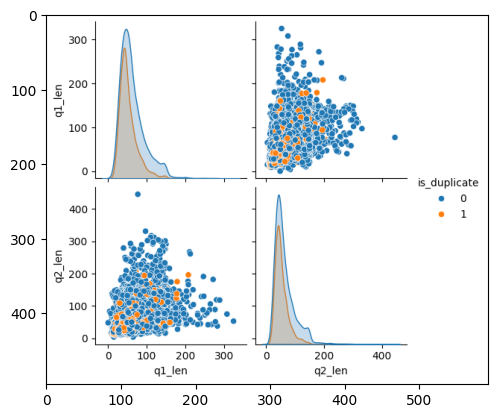

In [ ]:
img = plt.imread('/content/drive/MyDrive/Duplicate_question_pair/photos/pairplot_preprocess.png')
plt.imshow(img)

In [ ]:
import distance

def fetch_length_features(row):
    q1 = row['question1']
    q2 = row['question2']

    length_features = [0.0]*7

    # Converting the Sentence into Tokens:
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return length_features

    #no of tokens in question1
    length_features[0] = len(q1_tokens)

    #no of tokens in question2
    length_features[1] = len(q2_tokens)

    # Absolute length features
    length_features[2] = abs(len(q1_tokens) - len(q2_tokens))

    #Average Token Length of both Questions
    length_features[3] = (len(q1_tokens) + len(q2_tokens))/2

    #longest common substring
    strs = list(distance.lcsubstrings(q1, q2))
    if strs:
        length_features[4] = len(strs[0])
        #ratio of longest common substring to min question len
        length_features[5] = len(strs[0]) / min(len(q1), len(q2))
        #ratio of longest common substring to max question len
        length_features[6] = len(strs[0]) / max(len(q1), len(q2))

    return length_features

length_features = df.apply(fetch_length_features, axis=1)

df['q1_token_no'] = list(map(lambda x: x[0], length_features))
df['q2_token_no'] = list(map(lambda x: x[1], length_features))
df['abs_len_diff'] = list(map(lambda x: x[2], length_features))
df['mean_len'] = list(map(lambda x: x[3], length_features))
df['longest_substr'] = list(map(lambda x: x[4], length_features))
df['longest_substr_ratio_min'] = list(map(lambda x: x[5], length_features))
df['longest_substr_ratio_max'] = list(map(lambda x: x[6], length_features))

#sns.pairplot(df[['q1_token_no', 'q2_token_no', 'abs_len_diff', 'mean_len','longest_substr', 'longest_substr_ratio_min', 'longest_substr_ratio_max', 'is_duplicate']], hue='is_duplicate')

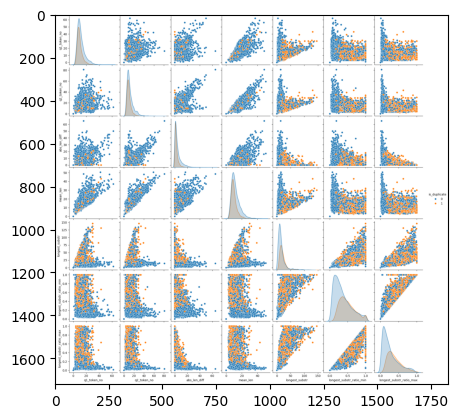

In [ ]:
img = plt.imread('/content/drive/MyDrive/Duplicate_question_pair/photos/pairplot1.png')
plt.imshow(img)

In [ ]:
from nltk.corpus import stopwords

def fetch_token_features(row):
  q1 = row['question1']
  q2 = row['question2']

  STOP_WORDS = stopwords.words("english")

  token_features = [0.0]*11

  # Converting the Sentence into Tokens:
  q1_tokens = q1.split()
  q2_tokens = q2.split()

  if len(q1_tokens) == 0 or len(q2_tokens) == 0:
    return token_features

  # Get the non-stopwords in Questions
  q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
  q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])

  #Get the stopwords in Questions
  q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
  q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])

  # Get the common non-stopwords from Question pair
  common_word_count = len(q1_words.intersection(q2_words))

  # Get the common stopwords from Question pair
  common_stop_count = len(q1_stops.intersection(q2_stops))

  # Get the common Tokens from Question pair
  common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))

  token_features[0]=common_token_count#common words
  token_features[1]=len(q1_tokens)+len(q2_tokens)#total words
  token_features[2]=token_features[0]/token_features[1];#ratio of common to total
  token_features[3] = common_word_count / (min(len(q1_words), len(q2_words)) + 0.0001)
  token_features[4] = common_word_count / (max(len(q1_words), len(q2_words)) + 0.0001)
  token_features[5] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + 0.0001)
  token_features[6] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + 0.0001)
  token_features[7] = common_token_count / (min(len(q1_tokens), len(q2_tokens)))
  token_features[8] = common_token_count / (max(len(q1_tokens), len(q2_tokens)))

  # Last word of both question is same or not
  token_features[9] = int(q1_tokens[-1] == q2_tokens[-1])

  # First word of both question is same or not
  token_features[10] = int(q1_tokens[0] == q2_tokens[0])


  return token_features

token_features = df.apply(fetch_token_features, axis=1)

df["common_words"] = list(map(lambda x: x[0], token_features))
df["total_words"] = list(map(lambda x: x[1], token_features))
df["ratio_of_common_to_total"] = list(map(lambda x: x[2], token_features))
df["cwc_min"] = list(map(lambda x: x[3], token_features))
df["cwc_max"] = list(map(lambda x: x[4], token_features))
df["csc_min"] = list(map(lambda x: x[5], token_features))
df["csc_max"] = list(map(lambda x: x[6], token_features))
df["ctc_min"] = list(map(lambda x: x[7], token_features))
df["ctc_max"] = list(map(lambda x: x[8], token_features))
df["last_word_eq"] = list(map(lambda x: x[9], token_features))
df["first_word_eq"] = list(map(lambda x: x[10], token_features))

#sns.pairplot(df[["common_words","total_words","ratio_of_common_to_total","cwc_min", "cwc_max", "csc_min", "csc_max", "ctc_min", "ctc_max", "last_word_eq", "first_word_eq", 'is_duplicate']], hue='is_duplicate')

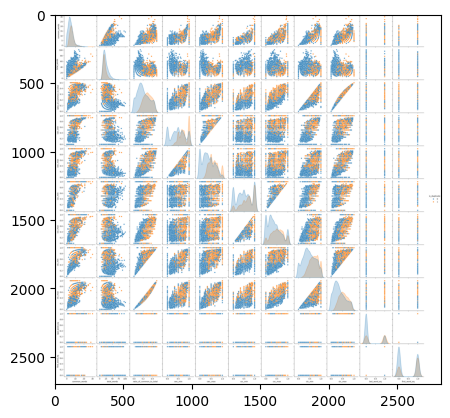

In [ ]:
img = plt.imread('/content/drive/MyDrive/Duplicate_question_pair/photos/pairplot2.png')
plt.imshow(img)

In [ ]:
from fuzzywuzzy import fuzz

def fetch_fuzzy_features(row):

    q1 = row['question1']
    q2 = row['question2']

    fuzzy_features = [0.0]*4

    # fuzz_ratio
    fuzzy_features[0] = fuzz.QRatio(q1, q2)

    # fuzz_partial_ratio
    fuzzy_features[1] = fuzz.partial_ratio(q1, q2)

    # token_sort_ratio
    fuzzy_features[2] = fuzz.token_sort_ratio(q1, q2)

    # token_set_ratio
    fuzzy_features[3] = fuzz.token_set_ratio(q1, q2)

    return fuzzy_features

fuzzy_features = df.apply(fetch_fuzzy_features, axis=1)

df['fuzz_ratio'] = list(map(lambda x: x[0], fuzzy_features))
df['fuzz_partial_ratio'] = list(map(lambda x: x[1], fuzzy_features))
df['token_sort_ratio'] = list(map(lambda x: x[2], fuzzy_features))
df['token_set_ratio'] = list(map(lambda x: x[3], fuzzy_features))

#sns.pairplot(df[['fuzz_ratio', 'fuzz_partial_ratio','token_sort_ratio','token_set_ratio', 'is_duplicate']],hue='is_duplicate')

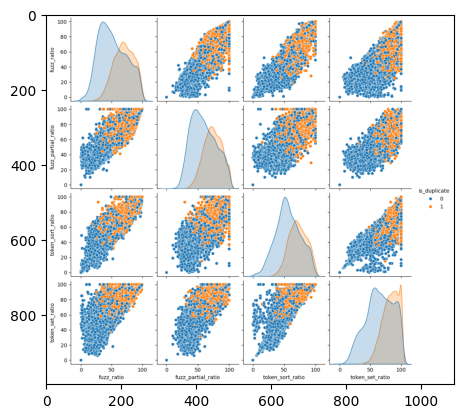

In [ ]:
img = plt.imread('/content/drive/MyDrive/Duplicate_question_pair/photos/pairplot3.png')
plt.imshow(img)

to save any result write result_name.to_csv('result.csv', index=false)
and next time just write example-
df = pd.read_csv('/content/drive/MyDrive/result.csv')

In [ ]:
! pip install gensim

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df1 = pd.read_csv('/content/drive/MyDrive/Duplicate_question_pair/word2vec.csv')

In [ ]:
df = df1.sample(15000, random_state = 1)

In [ ]:
del df1

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate']), df['is_duplicate'], test_size=0.25, random_state=0)

NameError: name 'df' is not defined

In [ ]:
X_train

,q1_len,q2_len,q1_token_no,q2_token_no,abs_len_diff,mean_len,longest_substr,longest_substr_ratio_min,longest_substr_ratio_max,common_words,...,question2_embedding_290,question2_embedding_291,question2_embedding_292,question2_embedding_293,question2_embedding_294,question2_embedding_295,question2_embedding_296,question2_embedding_297,question2_embedding_298,question2_embedding_299
250363,36,44,7.0,9.0,2.0,8.0,36.0,1.000000,0.818182,7.0,...,-0.134382,0.025024,-0.114397,-0.018842,-0.031738,0.060268,-0.016139,-0.014125,0.012004,-0.020229
351836,125,183,27.0,43.0,16.0,35.0,14.0,0.112000,0.076503,15.0,...,-0.044101,0.050033,-0.126237,-0.039050,-0.099952,-0.024756,0.016382,-0.027253,0.025295,-0.030053
38369,37,39,8.0,8.0,0.0,8.0,17.0,0.459459,0.435897,7.0,...,-0.109166,-0.011549,-0.016205,-0.004813,0.005912,0.005432,-0.013654,-0.080832,0.049526,-0.133719
289608,42,60,9.0,12.0,3.0,10.5,8.0,0.190476,0.133333,2.0,...,-0.123177,-0.056559,-0.102117,-0.000910,-0.028168,0.151601,0.054535,0.053630,0.068919,-0.042180
80600,66,85,14.0,16.0,2.0,15.0,9.0,0.136364,0.105882,9.0,...,-0.099431,-0.036514,-0.017934,-0.070435,-0.012797,0.034149,-0.020426,-0.073619,0.002579,-0.056900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134106,27,41,5.0,8.0,3.0,6.5,15.0,0.555556,0.365854,2.0,...,-0.042062,0.026794,0.047529,0.012137,0.028495,0.065177,-0.029018,-0.060739,0.020142,-0.029541
87698,40,40,8.0,8.0,0.0,8.0,9.0,0.225000,0.225000,7.0,...,-0.086988,-0.078918,-0.076311,-0.033813,0.025652,-0.025410,0.064314,-0.009173,-0.011370,0.009186
347861,72,28,14.0,6.0,8.0,10.0,9.0,0.321429,0.125000,4.0,...,0.008037,-0.013623,-0.064764,-0.015869,-0.034229,0.068811,0.199023,0.041797,-0.013232,0.010889
109282,89,53,15.0,10.0,5.0,12.5,7.0,0.132075,0.078652,1.0,...,-0.119255,0.027673,-0.089185,-0.006422,0.011682,0.084445,0.060754,0.022635,0.072705,-0.062817


In [ ]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier()

In [ ]:
from sklearn.model_selection import GridSearchCV
parameter={'criterion':['log_loss'],
           'max_depth':[None,3,5],
           'max_samples':[0.5,0.75,1.0],
           'max_features':['sqrt', 'log2', 0.5, 1.0],
          }

In [ ]:
classifier_regressor = GridSearchCV(classifier, param_grid = parameter, scoring = 'accuracy', cv = 5, verbose = 2)

In [12]:
classifier_regressor.fit(X_train,y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END criterion=log_loss, max_depth=None, max_features=sqrt, max_samples=0.5; total time=  19.8s
[CV] END criterion=log_loss, max_depth=None, max_features=sqrt, max_samples=0.5; total time=  20.7s
[CV] END criterion=log_loss, max_depth=None, max_features=sqrt, max_samples=0.5; total time=  19.1s
[CV] END criterion=log_loss, max_depth=None, max_features=sqrt, max_samples=0.5; total time=  17.7s
[CV] END criterion=log_loss, max_depth=None, max_features=sqrt, max_samples=0.5; total time=  18.1s
[CV] END criterion=log_loss, max_depth=None, max_features=sqrt, max_samples=0.75; total time=  25.4s
[CV] END criterion=log_loss, max_depth=None, max_features=sqrt, max_samples=0.75; total time=  25.3s
[CV] END criterion=log_loss, max_depth=None, max_features=sqrt, max_samples=0.75; total time=  25.2s
[CV] END criterion=log_loss, max_depth=None, max_features=sqrt, max_samples=0.75; total time=  25.2s
[CV] END criterion=log_loss, max_d

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['log_loss'], 'max_depth': [None, 3, 5],
                         'max_features': ['sqrt', 'log2', 0.5, 1.0],
                         'max_samples': [0.5, 0.75, 1.0]},
             scoring='accuracy', verbose=2)

In [13]:
classifier_regressor.best_params_

{'criterion': 'log_loss',
 'max_depth': None,
 'max_features': 0.5,
 'max_samples': 1.0}

In [14]:
y_pred = classifier_regressor.predict(X_test)

In [15]:
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix
score=accuracy_score(y_pred,y_test)
print("Accuracy : ", score)
print("Confusion Matrix : ")
print(confusion_matrix(y_pred, y_test))

Accuracy :  0.7736
Confusion Matrix : 
[[1953  443]
 [ 406  948]]


In [16]:
import pickle

In [17]:
pickle.dump(classifier_regressor,open('/content/model1','wb'))

In [18]:
! cp model1 '/content/drive/MyDrive'

In [ ]:
import joblib

In [ ]:
joblib.dump(classifier_regressor,'/content/model2')